In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

torch.device(device)

device(type='cuda')

In [22]:
# Classic trainer
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: torch.device,
        save_every: int
    ):
        self.gpu_id = gpu_id
        self.model = model
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.validation_steps = [{"val_loss: ": 10000.0, "val_acc": 0}]

    
    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = torch.nn.CrossEntropyLoss()(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        # b_sz = len(next(iter(self.train_data)))
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            
            self._run_batch(source, targets)
    
    def _accuracy(self, outputs, labels):
        outputs = outputs.to(self.gpu_id)
        labels = labels.to(self.gpu_id)
        out = self.model(outputs)
        loss = nn.functional.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        acc = (torch.tensor(torch.sum(preds == labels).item() / len(preds)))
        val = {"val_loss: ": loss, "val_acc": acc}
        self.validation_steps.append(val)
        print(val)
    
    def _validation_step(self):
        source, targets = next(iter(self.train_data))
        self._accuracy(source, targets)
        
            
    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        torch.save(ckp, "checkpoint.pt")
        print(f"epoch: {epoch}, gpu_id: {self.gpu_id}, val_loss_acc: {self.validation_steps[-1]}")
    
    def train(self, max_epochs):
        for i in range(max_epochs):
            self._run_epoch(i)
            self._validation_step()
            if (i % self.save_every) == 0:
                self._save_checkpoint(i)
                



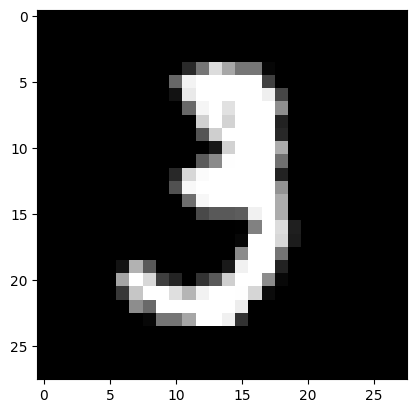

In [23]:
dataset = MNIST(root="data/", download=True)
image, label = dataset[10]
plt.imshow(image, cmap="gray")

In [24]:
mnist_dataset = MNIST(root="data/", train=True, transform=transforms.ToTensor())

In [25]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
print(len(train_data), len(validation_data))

50000 10000


In [26]:
shape = train_data.dataset.data.shape
input_size = shape[-1] * shape[-2]
num_classes = len(train_data.dataset.classes)

In [27]:
class MnistModel(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.linear(x)

In [28]:
model = MnistModel(input_size, num_classes)
model.to(device)

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [32]:
train_loader = DataLoader(
    train_data,
    batch_size=2048,
    shuffle=False
)

trainer = Trainer(model, train_loader, torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), device, 12)

In [33]:
trainer.train(5)

{'val_loss: ': tensor(0.4096, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8965)}
epoch: 0, gpu_id: cuda, val_loss_acc: {'val_loss: ': tensor(0.4096, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8965)}
{'val_loss: ': tensor(0.4063, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8979)}
{'val_loss: ': tensor(0.4030, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8970)}
{'val_loss: ': tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8975)}
{'val_loss: ': tensor(0.3971, device='cuda:0', grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.8975)}


Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

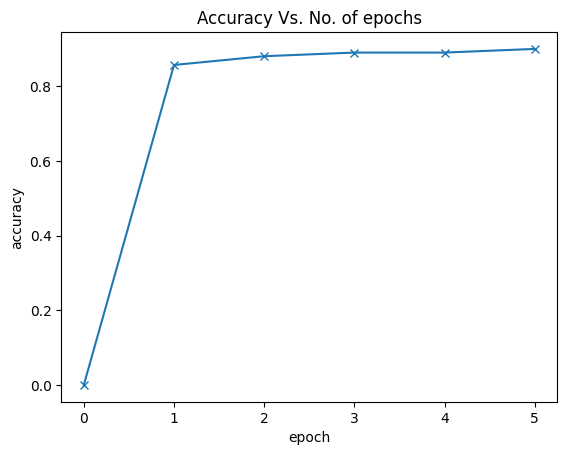

In [31]:

accuracies = [step['val_acc'] for step in trainer.validation_steps]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

In [22]:
trainer._validation_step()

tensor([4, 2, 2, 7]) tensor([1, 5, 6, 8])
